In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
from scipy.spatial import ConvexHull

In [2]:
def Mass_histogram(file_path):
    F = h5py.File(file_path, "r")
    cloud_groups =[]
    total_masses = []
    new_bins= np.linspace(4,8,50)
    bin_size= (new_bins[1])- (new_bins[0])
    center_bins= 0.5*(new_bins[:-1]+new_bins[1:])
    for key in F.keys():
        cloud_groups.append(key)
    # the above line gives us all the cloud groups in the file in a list
    # now we go inside every cloud calculate the total mass of the cloud and append it to a list
    for cloud_group in cloud_groups:
        particle_masses = F[cloud_group + "/PartType0/Masses"][:]
        total_masses.append(np.sum(particle_masses))
    total_masses = np.array(total_masses)
    total_masses = total_masses*(1e10)
    total_masses= np.log10(total_masses)
    # now we have the total mass of all the clouds in the list total_masses
    # we have to plot a histogram of the 2 arrays the cloud_groups and the total_masses
    hist, bin_edges = np.histogram(total_masses, bins=new_bins)
    plt.figure()
    plt.plot(center_bins,hist/bin_size,color="black")
    plt.xlabel('log(Total Mass/sun Mass)')
    plt.yscale('log')
    plt.ylabel('dN/dlog_10(M)- Number of clouds per unit mass')
    plt.title('Probability Density Histogram of log of Total Masses of Clouds')
    plt.show()



In [3]:
def virial_histogram(dat_file_path):
    # Reading the data file with the appropriate separator and header option
    file = pd.read_csv(dat_file_path, sep='\t', header=None, comment='#')
    new_bins=np.linspace(0,5,50)
    center_bins= 0.5*(new_bins[:-1]+new_bins[1:])
    
    # Extracting the Reff parameter which is the 10th column
    virial_parameter = file.iloc[:, 10]
    
    # Plotting the histogram of the virial parameter
    hist, bin_edges = np.histogram(virial_parameter, bins=new_bins, density=True)
    print(bin_edges)
    plt.figure()
    plt.plot(center_bins,hist,color="black")
    plt.xlabel('Virial Parameter')
    plt.ylabel('Number of Clouds')
    plt.yscale('log')
    plt.title('Histogram of Virial Parameters of Clouds')
    plt.savefig('Virial_Parameter_Histogram.pdf')
    plt.show()



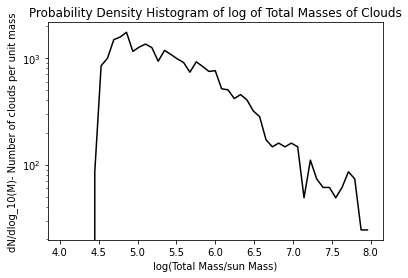

In [4]:
Mass_histogram("Clouds_600_n1_alpha5.hdf5")

[0.         0.10204082 0.20408163 0.30612245 0.40816327 0.51020408
 0.6122449  0.71428571 0.81632653 0.91836735 1.02040816 1.12244898
 1.2244898  1.32653061 1.42857143 1.53061224 1.63265306 1.73469388
 1.83673469 1.93877551 2.04081633 2.14285714 2.24489796 2.34693878
 2.44897959 2.55102041 2.65306122 2.75510204 2.85714286 2.95918367
 3.06122449 3.16326531 3.26530612 3.36734694 3.46938776 3.57142857
 3.67346939 3.7755102  3.87755102 3.97959184 4.08163265 4.18367347
 4.28571429 4.3877551  4.48979592 4.59183673 4.69387755 4.79591837
 4.89795918 5.        ]


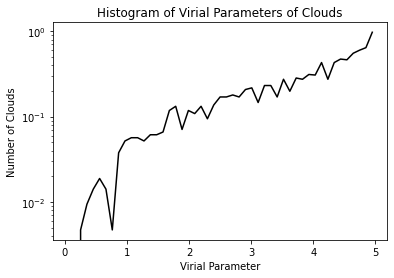

In [15]:
virial_histogram('bound_600_n1_alpha5.dat')

In [32]:
def cloud_size(path_to_file):
    # Reading the data file with the appropriate separator and header option
    file = pd.read_csv(path_to_file, sep='\t', header=None, comment='#')
    new_bins=np.linspace(0,3000,200)
    center_bins= 0.5*(new_bins[:-1]+new_bins[1:])
    cloud_parameter = file.iloc[:, 7]*1e3
    print(cloud_parameter[1])
    
    # Plotting the histogram of the virial parameter
    hist, bin_edges = np.histogram(cloud_parameter, bins=new_bins)
    plt.figure()
    plt.plot(center_bins,hist, color='black')
    plt.xlabel('Size of clouds in R_eff value (pc)')
    plt.yscale('log')
    plt.ylabel( 'Number of Clouds')
    plt.title('Histogram of Size of Clouds')
    plt.savefig('Cloud_Size_Histogram.pdf')
    plt.show()


1963.35174820944


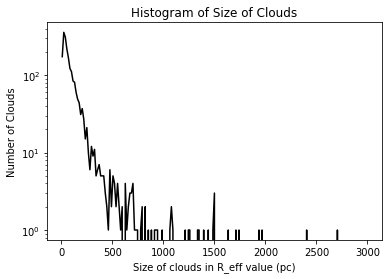

In [7]:
cloud_size("bound_600_n1_alpha5.dat")


In [72]:
def density_plot_PDF(file_path):
    # we want to have a big array of the density of all the particles in all the clouds
    # then we calculate its mean and take the ln(d/d_mean) where d is the density of each particle
    # we plot the PDF of this 
    F = h5py.File(file_path, "r")
    new_bins= np.linspace(-4,6,80)
    center_bins= 0.5*(new_bins[:-1]+new_bins[1:])
    cloud_groups= cloud_size_array(file_path)
    # the above line gives us all the cloud groups in the file in a list
    # now we go inside every cloud calculate the total mass of the cloud and append it to a list
    cloud_groups=cloud_groups
    plt.figure()
    n=0
    for cloud_group in cloud_groups:
        particle_density_each_cloud = F[cloud_group + "/PartType0/Density"][:]*10
        particle_density_each_cloud= np.array(particle_density_each_cloud)
        variance= np.var( particle_density_each_cloud)
        total= np.sum(particle_density_each_cloud)
        length= np.size(particle_density_each_cloud)
        mean= total/length
        particle_density_each_cloud= particle_density_each_cloud*(1/mean)
        particle_density_each_cloud= np.log( particle_density_each_cloud)
        #hist, bin_edges = np.histogram(particle_density_each_cloud, bins=new_bins, density=True)
        #plt.plot(center_bins,hist,color='black', lw=1,alpha=1)
        if(variance<1 and n<20):
            plt.hist(particle_density_each_cloud,bins=new_bins, density=True, histtype='step')
            n=n+1
        #plt.yscale('log')
      
    plt.title("Histogram with Density=True (Natural Log of Values)")
    plt.xlabel("ln(density/density_mean) for every particle")
    plt.ylabel("Probability Density")
    #plt.yscale('log')
    plt.ylim([1e-3, 1])
    plt.xlim(-4,6)
    plt.show()

In [73]:
def cloud_size_array(file_path):
    F = h5py.File(file_path, "r")
    # we want to maintain an array that has all the cloud numbers in ascending order 
    cloud_details={}
    cloud_groups=[]
    for key in F.keys():
        cloud_groups.append(key)
    for cloud_group in cloud_groups:
        cloud_details[cloud_group]= len(F[cloud_group + "/PartType0/Masses"][:])
    sorted_dict = sorted(cloud_details.items(), key=lambda x: x[1],reverse=True)
    sorted_keys = [item[0] for item in sorted_dict]
    return sorted_keys

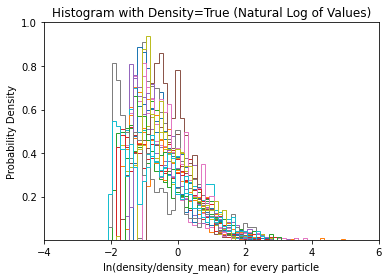

In [74]:
density_plot_PDF('/home/ajain/cloudphinder/Clouds_312_n1_alpha5.hdf5')

In [3]:
import pandas as pd
import h5py
import numpy as np
from scipy.spatial import ConvexHull

class cloud_data:
    def __init__(self,dat_file_array,hdf5_file_array,file_name):
        self.dat_file_array= dat_file_array
        self.hdf5_file_array= hdf5_file_array
        self.file_name= file_name

    def density_data_file(self,cutoff=None):
        if (cutoff!= None):
            array_2d = []
            array_3d = []
            for dat_file, hdf5_file in zip(self.dat_file_array, self.hdf5_file_array):
                file = pd.read_csv(dat_file, sep='\t', header=None, comment='#')
                F = h5py.File(hdf5_file, "r")
                cloud_groups= self.cloud_name_by_size(hdf5_file,dat_file,cutoff) 
                for i, cloud in enumerate(cloud_groups):
                    points = F[cloud + "/PartType0/Coordinates"][:, :2]
                    hull = ConvexHull(points)
                    hull_area = hull.volume
                    mass = file.iloc[:, 0][i]*1e10
                    hull_volume= hull2.volume
                    density_2d = float(mass / hull_area)
                    array_2d.append(density_2d)
                    density_3d = mass / hull_volume
                    array_3d.append(density_3d)
                    
            array_2d = np.array(array_2d)*(1/1e6) # converts the density to Msun/pc^2
            array_3d = np.array(array_3d)*(1/1e9) # converts the density to Msun/pc^3
            file_name = self.file_name
            cloud_df = pd.DataFrame({'2D Density': array_2d, '3D Density': array_3d})
            cloud_df.to_csv(file_name, sep='\t', index=False, float_format='%.6f')
        else:  
            array_2d = []
            array_3d = []
            for dat_file, hdf5_file in zip(self.dat_file_array, self.hdf5_file_array):
                file = pd.read_csv(dat_file, sep='\t', header=None, comment='#')
                F = h5py.File(hdf5_file, "r")
                for i, cloud in enumerate(F.keys()):
                    points = F[cloud + "/PartType0/Coordinates"][:, :2]
                    points3d=  F[cloud + "/PartType0/Coordinates"][:, :3]
                    hull = ConvexHull(points)
                    hull_area = hull.volume
                    mass = file.iloc[:, 0][i]*1e10
                    hull2= ConvexHull(points3d)
                    hull_volume= hull2.volume
                    density_2d = float(mass / hull_area)
                    array_2d.append(density_2d)
                    density_3d = mass / hull_volume
                    array_3d.append(density_3d)
    
            array_2d = np.array(array_2d)*(1/1e6) # converts the density to Msun/pc^2
            array_3d = np.array(array_3d)*(1/1e9) # converts the density to Msun/pc^3
            file_name = self.file_name
            cloud_df = pd.DataFrame({'2D Density(M_sun/pc^2)': array_2d, '3D Density(M_sun/pc^3)': array_3d})
            cloud_df.to_csv(file_name, sep='\t', index=False, float_format='%.6f')
            
    def cloud_name_by_size(self,file_path, dat_file_path,cutoff_particle_size):
        """"
        Args:
        file_path_array: hdf5 file snapshots 
        dat_file_path_array:  dat file of hdf5 file snapshots
        cutoff_particle_size: cutoff number of particles to form the cloud
        return: returns an array of cloud numbers in the form of strings with the format Cloud#### of the clouds with
        more than 'cutoff' number of particles"""
        F = h5py.File(file_path, "r")
        file = pd.read_csv(dat_file_path, sep='\t', header=None, comment='#')
        number_of_particles = file.iloc[:, 9].tolist()
        cloud_groups=[]
        cloud_dict={}
        total_masses = []
        return_keys=[]
        for key in F.keys():
            cloud_groups.append(key)
        for index,cloud_group in enumerate(cloud_groups):
            cloud_dict[cloud_group]= number_of_particles[index]
        sorted_dict = sorted(cloud_dict.items(), key=lambda x: x[1],reverse=True)
        sorted_keys = [item[0] for item in sorted_dict]
        for i in sorted_dict:
            if(i[1]>cutoff_particle_size):
                return_keys.append(i[0])
        F.close()
        return return_keys
    # we now want to extract dispersion velocity in the z direction, to calculate that we need
    # to calculate the dispersion velocity we create the following function
    def dispersion_velocity_z_direction(self):
        """The function calculates dispersion velocity for every cloud in every snapshot 
        so we need all the hdf5 files and the dat files and it should return an array contaning the dispersion
        velocities and the length of the numpy array is basically the total number of clouds
        Args:
        dat_file_array: array of data files
        hdf5_File_array: array of hdf5 files
        Return: array of dispersion velocities in the z direction in a csv file"""
        dispersion_velocity_array=[]
        for hdf5_file, dat_file in zip(self.hdf5_file_array, self.dat_file_array):
            F= h5py.File(hdf5_file, "r")
            file= pd.read_csv(dat_file, sep='\t', header=None, comment='#')
            for cloud in F.keys():
                # every cloud has a center of mass velocity and we want to calculate that 
                velocity_array= np.array(F[cloud + "/PartType0/Velocities"][:])
                particle_masses = np.array(F[cloud + "/PartType0/Masses"][:])*1e10
                center_of_mass_z_velocity= (np.sum(particle_masses*velocity_array[:,2])/np.sum(particle_masses))
                velocity_z= velocity_array[:,2]
                v_i= velocity_z- center_of_mass_z_velocity
                dispersion_velocity = np.sqrt(np.sum(particle_masses*v_i**2)/np.sum(particle_masses))
                dispersion_velocity_array.append(dispersion_velocity)
                
        dispersion_velocity_array=np.array(dispersion_velocity_array)
        file_name = self.file_name
        cloud_df = pd.DataFrame({'Dispersion velocity in Z direction(Km/s)':dispersion_velocity_array })
        cloud_df.to_csv(file_name, sep='\t', index=False, float_format='%.6f')
        
    def Galactor_centric_distance(self,galactic_hdf5_file_array):
        """We calculate the distance of the cloud from the galaxtic center and the projected distance of the 
        cloud on the galactic plane
        Args:
        dat_file_array: array of the data files
        hdf5_File_array: array of hdf5 files
        file_name: The file where the output is saved
        galactic_hdf5_file: The galactic file array with galactic center and matrix data 
        Returns: CSV file with projected cloud distance and distance from galactic center"""
        all_norms=[]
        for dat_file, galaxy_file in zip(self.dat_file_array, galactic_hdf5_file_array):
            file= pd.read_csv(dat_file, sep='\t', header=None, comment='#')
            F= h5py.File(galaxy_file,"r")
            center= F["/centering"][:]
            cloud_center= file.iloc[:,1:4]
            cloud_center_array = cloud_center.values
            dif= cloud_center_array- center
            norms = np.linalg.norm(dif, axis=1)
            all_norms.extend(norms)
        df = pd.DataFrame(all_norms, columns=["Cloud distance from galactic center(Kpc)"])
        df.to_csv(self.file_name, sep='\t', index=False, float_format='%.6f')
            
    def projected_distance(self,galactic_hdf5_file_array):
        """We calculate the projected distance of the cloud on the galactic plane
        Args:
        dat_file_array: array of the data files
        hdf5_File_array: array of hdf5 files
        file_name: The file where the output is saved
        galactic_hdf5_file: The galactic file array with galactic center and matrix data 
        Returns: CSV file with projected cloud distance from the galactic plane"""
        all_projections=[]
        for dat_file, galaxy_file in zip(self.dat_file_array, galactic_hdf5_file_array):
            file= pd.read_csv(dat_file, sep='\t', header=None, comment='#')
            F= h5py.File(galaxy_file,"r")
            center= F["/centering"][:]
            proj=  F["/ProjectionMatrix"][:]
            cloud_center= file.iloc[:,1:4]
            cloud_center_array = np.array(cloud_center)
            result = np.einsum('ij,jk->ik', cloud_center_array, proj)
            gal_proj = np.matmul(center,proj)
            answer= np.abs(gal_proj[2]-result[:,2])
            all_projections.extend(answer)
            
        df = pd.DataFrame(all_projections, columns=["Projected cloud distance on galactic plane(Kpc)"])
        df.to_csv(self.file_name, sep='\t', index=False, float_format='%.6f')
        
    def cloud_particle_data(self):
            """We want to calculate the mean density and variance in particle density in each cloud
            Args:
            dat_file_array: array of the data files
            hdf5_File_array: array of hdf5 files
            file_name: The file where the output is saved
            Returns: a CSV file contaning the mean density of every cloud and the variance in the particle density 
            in every cloud"""
            mean_array=[]
            variance_array=[]
            diff=[]
            num_particles=[]
            for hdf5_file, dat_file in zip(self.hdf5_file_array, self.dat_file_array):
                F= h5py.File(hdf5_file, "r")
                file= pd.read_csv(dat_file, sep='\t', header=None, comment='#')
                for cloud in F.keys(): 
                    density_array= np.array(F[cloud + "/PartType0/Density"][:])*10 # to convert the units to M_sun/pc^3
                    num_particles.append(len(density_array))
                    mean= np.mean(density_array)
                    variance= np.log10(np.percentile(density_array,84))-np.log10(np.percentile(density_array,16))
                    mean_array.append(mean)
                    variance_array.append(variance)
                    difference= np.log10(np.max(density_array))- np.log10(np.min(density_array))
                    diff.append(difference)
                   
            print(np.sum(np.array(num_particles)>100),len(num_particles)) 
            dif= np.array(diff)
            array_mean= np.array(mean_array)
            array_variance= np.array(variance_array)
            file_name = self.file_name
            cloud_df = pd.DataFrame({'Mean Particle density':array_mean,  'density variance': array_variance, 'max- min density': dif})
            cloud_df.to_csv(file_name, sep='\t', index=False, float_format='%.10f')
            
            
        
         
    def particle_density_plots(self ,file_name):
        
        mass=[]
        num_particles=[]
        for hdf5_file in self.hdf5_file_array:
            F= h5py.File(hdf5_file, "r")
            for cloud in F.keys():
                mass_array= np.array(F[cloud + "/PartType0/Masses"][:])*1e10
                mass_sum= np.sum(mass_array)
                mass.append(mass_sum)
                num_particles.append(len(mass_array))

        df = pd.read_csv(file_name, sep='\t')
        particle_array = df.to_numpy()
        variance_array = particle_array[:, 1].astype(float).reshape(-1)
        log_variance= np.log10(variance_array)
        plt.figure(figsize=(10, 6))
        #plt.hist(log_variance, bins=50, alpha=0.7, color='blue', edgecolor='black')
        plt.scatter(log_variance, np.log10(mass))
        plt.xlabel('log Variance')
        plt.ylabel('mass in solar masses')
        plt.title('mass vs log variance')
        minimum= np.min(log_variance)
        maximum= np.max(log_variance)
        plt.xlim([minimum, maximum])
        plt.grid(True)
        plt.show()

        plt.scatter(log_variance, np.log10(num_particles))
        plt.xlabel('log variance')
        plt.ylabel('log of num particles')
        minimum= np.min(log_variance)
        maximum= np.max(log_variance)
        plt.xlim([minimum, 5])
        plt.grid(True)
        plt.show()
       
        plt.scatter(np.log10(num_particles), np.log10(mass))
        plt.show()


        plt.hist(log_variance, bins=50, alpha=0.7, color='blue', edgecolor='black')
        plt.show()
                
                
    def log_density_space_data(self, cutoff):
            '''The function extracts s= ln(density/mean_density)
            and its defined variance as the difference between the 84th percentile and 16th percentile data 
            '''
            s_array=[]
            var_s=[]
            for hdf5_file in self.hdf5_file_array:
                F= h5py.File(hdf5_file, "r")
                for cloud in F.keys():
                    density_array= np.array(F[cloud + "/PartType0/Density"][:])*10 # to convert the units to M_sun/pc^3
                    variance= np.log10(np.percentile(density_array,84))-np.log10(np.percentile(density_array,16))
                    s= np.log(density_array/(np.mean(density_array)))
                    if(len(density_array)>cutoff):
                        mean_s= np.mean(s)
                        s_array.append(mean_s)
                        var_s.append(variance)
                    
                    
            var_s_numpy = np.array(var_s)
            s_array_numpy= np.array(s_array)
            file_name = self.file_name
            cloud_df = pd.DataFrame({'Mean of s= ln(density/mean_density)': s_array_numpy,  'variance defined by quartile': var_s_numpy})
            cloud_df.to_csv(file_name, sep='\t', index=False, float_format='%.10f')
            
            
            
                    
        
             
             
        
        
        
                
                
                
    

In [4]:
string1= "/home/ajain/cloudphinder/Clouds_312_n1_alpha5.hdf5"
string2= "/home/ajain/cloudphinder/Clouds_356_n1_alpha5.hdf5"
string3= "/home/ajain/cloudphinder/Clouds_382_n1_alpha5.hdf5"
string4= "/home/ajain/cloudphinder/Clouds_412_n1_alpha5.hdf5"
string5= "/home/ajain/cloudphinder/Clouds_534_n1_alpha5.hdf5"
string6= "/home/ajain/cloudphinder/Clouds_591_n1_alpha5.hdf5"
string7= "/home/ajain/cloudphinder/Clouds_600_n1_alpha5.hdf5"
l1= [string1,string2,string3,string4,string5,string6,string7]
l2= ["/home/ajain/cloudphinder/bound_312_n1_alpha5.dat", "/home/ajain/cloudphinder/bound_356_n1_alpha5.dat","/home/ajain/cloudphinder/bound_382_n1_alpha5.dat","/home/ajain/cloudphinder/bound_412_n1_alpha5.dat","/home/ajain/cloudphinder/bound_534_n1_alpha5.dat","/home/ajain/cloudphinder/bound_591_n1_alpha5.dat","/home/ajain/cloudphinder/bound_600_n1_alpha5.dat"]
#data= cloud_data(l2,l1,"dispersion_data_file")
#data.dispersion_velocity_z_direction()
#data2= cloud_data(l2,l1, "density_data_file")
#data2.density_data_file()



In [6]:
galaxy_center_distance= cloud_data(l2,l1, "distance_from_galactic_center")
s1="/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_312.hdf5"
s2="/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_356.hdf5"
s3="/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_382.hdf5"
s4="/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_412.hdf5"
s5= "/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_534.hdf5"
s6= "/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_591.hdf5"
s7= "/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_600.hdf5"
l3= [s1,s2,s3,s4,s5,s6,s7]
galaxy_center_distance.Galactor_centric_distance(l3)
projection= cloud_data(l2,l1, "projected_distance_file")
projection.projected_distance(l3)


2115 11010


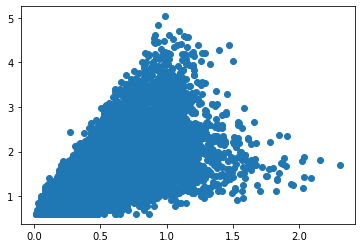

In [13]:
particle_data= cloud_data(l2,l1,"cloud_particle_density_data")
particle_data.cloud_particle_data()

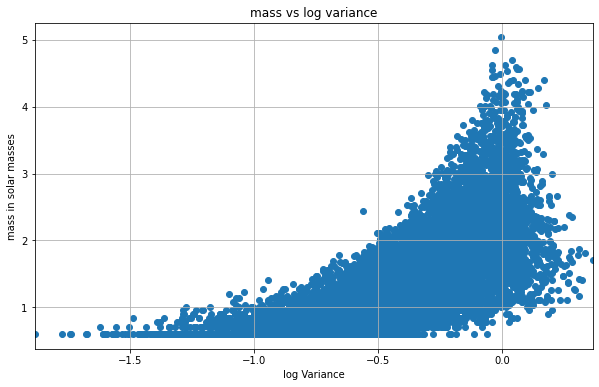

In [14]:
particle_data.mean_particle_density_cut(1e-4,'/home/ajain/cloudphinder/cloud_particle_density_data')

In [30]:
def cloud_name_density_cut(dat_file, hdf5_file):
    d= {}
    file = pd.read_csv(dat_file, sep='\t', header=None, comment='#')
    F = h5py.File(hdf5_file, "r")
    for i, cloud in enumerate(F.keys()):
        R_eff = file.iloc[:, 7][i]
        mass = file.iloc[:, 0][i]
        volume = 4 / 3 * np.pi * R_eff ** 3
        density_3d = mass / volume
        if(density_3d< 1e-1):
            d[cloud]= density_3d
            
        
    return d.keys()
            

In [4]:
string1= "/home/ajain/cloudphinder/Clouds_312_n1_alpha5.hdf5"
string2= "/home/ajain/cloudphinder/Clouds_356_n1_alpha5.hdf5"
string3= "/home/ajain/cloudphinder/Clouds_382_n1_alpha5.hdf5"
string4= "/home/ajain/cloudphinder/Clouds_412_n1_alpha5.hdf5"
string5= "/home/ajain/cloudphinder/Clouds_534_n1_alpha5.hdf5"
string6= "/home/ajain/cloudphinder/Clouds_591_n1_alpha5.hdf5"
string7= "/home/ajain/cloudphinder/Clouds_600_n1_alpha5.hdf5"
l1= [string1,string2,string3,string4,string5,string6,string7]
l2= ["/home/ajain/cloudphinder/bound_312_n1_alpha5.dat", "/home/ajain/cloudphinder/bound_356_n1_alpha5.dat","/home/ajain/cloudphinder/bound_382_n1_alpha5.dat","/home/ajain/cloudphinder/bound_412_n1_alpha5.dat","/home/ajain/cloudphinder/bound_534_n1_alpha5.dat","/home/ajain/cloudphinder/bound_591_n1_alpha5.dat","/home/ajain/cloudphinder/bound_600_n1_alpha5.dat"]

density_space_data= cloud_data(l2,l1, "density_space_data_particles>100_file")
density_space_data.log_density_space_data(100)

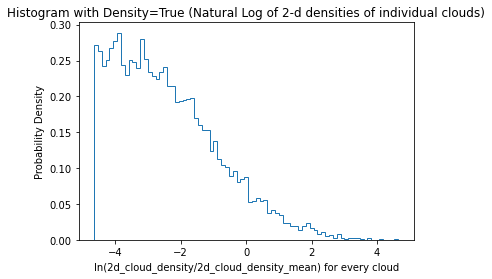

In [26]:
cloud_Density_PDF('/home/ajain/cloudphinder/density_data.dat')

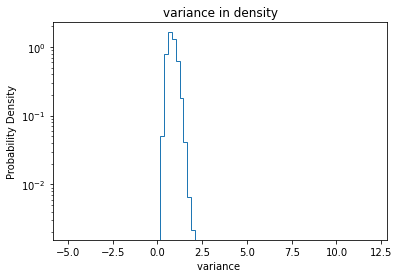

0.2749540551939251
1.9064755423319308


In [11]:
csv_file = '/home/ajain/cloudphinder/data_all_cutoff>=100'
df = pd.read_csv(csv_file, sep='\t')
new_bins= np.linspace(-5,12,80)
data_array = df.to_numpy()
# Split the data into input (2D densities) and output (3D densities)
var = data_array[:, 6].astype(float).reshape(-1)
#log_array= np.log(variance)
plt.hist(variance,bins=new_bins, density=True, histtype='step')      
plt.title("variance in density")
plt.xlabel("variance ")
plt.ylabel("Probability Density")
plt.yscale('log')
plt.show()
print(np.min(var))
print(np.max(var))

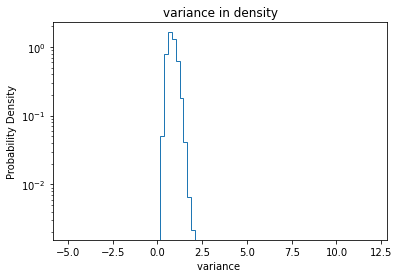

-2.7200356488647617
-0.0570165856524503


In [12]:
csv_file = '/home/ajain/cloudphinder/data_all_cutoff>=100'
df = pd.read_csv(csv_file, sep='\t')
new_bins= np.linspace(-5,12,80)
data_array = df.to_numpy()
# Split the data into input (2D densities) and output (3D densities)
s = data_array[:, 5].astype(float).reshape(-1)
#log_array= np.log(variance)
plt.hist(variance,bins=new_bins, density=True, histtype='step')      
plt.title("variance in density")
plt.xlabel("variance ")
plt.ylabel("Probability Density")
plt.yscale('log')
plt.show()
print(np.min(s))
print(np.max(s))

In [11]:
class molecular_cloud_data:
    
    def __init__(self, hdf5_array, dat_array, galactic_array, cutoff=0):
        self.hdf5_array = hdf5_array
        self.dat_array = dat_array
        self.galactic_array = galactic_array
        self.cutoff = cutoff
    
    def cloud_number_file_name(self):
        '''Takes in the hdf5_file_array and creates a dictionary with all the cloud numbers as values and the file 
        name as the key of the value 
        Example output: {"file_handle_of_first_file": [Cloud000, Cloud0001, Cloud0002.. ,Cloud9999]}'''
        cloud_number_dict = {}
        for hdf5_file, dat_file, galactic_file in zip(self.hdf5_array, self.dat_array, self.galactic_array):
            with h5py.File(hdf5_file, "r") as F:
                cloud_string = list(F.keys())
                cloud_number_dict[(hdf5_file, dat_file, galactic_file)] = cloud_string
        return cloud_number_dict
    
    def file_process(self, dict_key):
        '''Takes in file name and returns file handle'''
        F = h5py.File(dict_key[0], 'r')
        G = h5py.File(dict_key[2], "r")
        file = pd.read_csv(dict_key[1], sep='\t', header=None, comment='#')
        return F, file, G
    
    def density_2d(self, array_of_positions_2d, mass_array):
        '''Takes in the array of positions of particles and returns the 2D surface density in the units of M_sun/pc^2
        The array it takes in will be the array of positions from the cloud which passes the cutoff requirement
        Convert the masses array into M_sun units before passing to this function to avoid potential bugs. 
        '''
        hull = ConvexHull(array_of_positions_2d)
        hull_area = hull.volume
        density_2d = float(np.sum(mass_array) / hull_area) * (1 / 1e6)
        return density_2d
    
    def density_3d(self, array_of_positions_3d, mass_array):
        '''Takes in the array of positions of particles and returns the 3D density in the units of M_sun/pc^3
        The array it takes in will be the array of positions from the cloud which passes the cutoff requirement
        Convert the masses array into M_sun units before passing to this function to avoid potential bugs.
        '''
        hull = ConvexHull(array_of_positions_3d)
        hull_volume = hull.volume
        density_3d = float(np.sum(mass_array) / hull_volume) * (1 / 1e9) # to convert the density to M_sun/pc^3 units
        return density_3d
    
    def dispersion_velocity(self, mass_array, velocity_array):
        '''Takes in the velocity and mass array and returns the dispersion velocity in the z direction'''
        center_of_mass_z_velocity = np.sum(mass_array * velocity_array[:, 2]) / np.sum(mass_array)
        velocity_z = velocity_array[:, 2]
        v_i = velocity_z - center_of_mass_z_velocity
        dispersion_velocity = np.sqrt(np.sum(mass_array * v_i**2) / np.sum(mass_array))
        return dispersion_velocity
    
    def galactocentric_distance(self, galaxy_center_array, cloud_center_array):
        dif = cloud_center_array - galaxy_center_array
        norms = np.linalg.norm(dif)
        return norms
    
    def projected_distance(self, cloud_center_array, projection_matrix, galaxy_center):
        
        if cloud_center_array.ndim == 1:
            cloud_center_array = cloud_center_array.reshape(1, -1)
        
        result = np.einsum('ij,jk->ik', cloud_center_array, projection_matrix)
        gal_proj = np.dot(galaxy_center, projection_matrix)
        answer = np.abs(gal_proj[2] - result[:, 2])
        return answer[0]

    
    def mean_variance_particle_density(self, density_array):
        variance = np.log10(np.percentile(density_array, 84)) - np.log10(np.percentile(density_array, 16))
        s = np.log(density_array / np.mean(density_array))
        mean_s = np.mean(s)
        return mean_s, variance
    
    def data_file_store(self, output_file_name):
        '''This function uses all the above helper functions to store the values of 2D, 3D density, 
        dispersion velocity, projected distance to clouds, mean and variance of particle densities 
        '''
        cloud_num = self.cloud_number_file_name()
        file_exists = os.path.isfile(output_file_name)
        
        with open(output_file_name, 'a', newline='') as csvfile:
            fieldnames = ['2D', '3D', 'DV', 'GCD', 'PD', 'Mean', 'Variance']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter='\t')
        
            if not file_exists:
                writer.writeheader()
            a1=[]
            a2=[]
            a3=[]
            for file_path_tuple in cloud_num.keys():
                file_handle, dat_file_handle, galactic_file_handle = self.file_process(file_path_tuple)
                i=0
                for cloud in cloud_num[file_path_tuple]:
                    points2d = np.array(file_handle[cloud + "/PartType0/Coordinates"][:, :2])
                    points3d = np.array(file_handle[cloud + "/PartType0/Coordinates"][:, :3])
                    
                    if len(points3d)>=100: a1.append(len(points3d))
                    velocity_array = np.array(file_handle[cloud + "/PartType0/Velocities"][:])
                    density_array = np.array(file_handle[cloud + "/PartType0/Density"])*10 # convert to M_sun/pc^3
                    if len(density_array)>=100: a2.append(len(density_array))
                    particle_masses = np.array(file_handle[cloud + "/PartType0/Masses"])*1e10 # convert to M_sun units
                    if len(particle_masses)>=100: a3.append(len(particle_masses))
                    cloud_center_array = dat_file_handle.iloc[i, 1:4].values
                    galactic_center = galactic_file_handle['/centering'][:]
                    galaxy_projection = galactic_file_handle["/ProjectionMatrix"][:]
                    i=i+1
                    if (len(points3d) >= self.cutoff):
                        density_surface = self.density_2d(points2d, particle_masses)
                        density_volume = self.density_3d(points3d, particle_masses)
                        dispersion = self.dispersion_velocity(particle_masses, velocity_array)
                        galaxy_center_distance = self.galactocentric_distance(galactic_center, cloud_center_array)
                        projected = self.projected_distance(cloud_center_array, galaxy_projection, galactic_center)
                        mean_s, variance = self.mean_variance_particle_density(density_array)
                        
                        writer.writerow({
                            '2D': density_surface,
                            '3D': density_volume,
                            'DV': dispersion,
                            'GCD': galaxy_center_distance,
                            'PD': projected,
                            'Mean': mean_s,
                            'Variance': variance
                        })
            

                
        
        
                    
        

In [12]:
string1= "/home/ajain/cloudphinder/Clouds_312_n1_alpha5.hdf5"
string2= "/home/ajain/cloudphinder/Clouds_356_n1_alpha5.hdf5"
string3= "/home/ajain/cloudphinder/Clouds_382_n1_alpha5.hdf5"
string4= "/home/ajain/cloudphinder/Clouds_412_n1_alpha5.hdf5"
string5= "/home/ajain/cloudphinder/Clouds_534_n1_alpha5.hdf5"
string6= "/home/ajain/cloudphinder/Clouds_591_n1_alpha5.hdf5"
string7= "/home/ajain/cloudphinder/Clouds_600_n1_alpha5.hdf5"
string8= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_312_n1_alpha5.hdf5"
string9= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_356_n1_alpha5.hdf5"
string10= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_382_n1_alpha5.hdf5"
string11= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_412_n1_alpha5.hdf5"
string12= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_534_n1_alpha5.hdf5"
string13= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_591_n1_alpha5.hdf5"
string14= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_312_n1_alpha5.hdf5"
string15= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_356_n1_alpha5.hdf5"
string16= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_382_n1_alpha5.hdf5"
string17= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_412_n1_alpha5.hdf5"
string18= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_534_n1_alpha5.hdf5"
string19= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_591_n1_alpha5.hdf5"
string20= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_312_n1_alpha5.hdf5"
string21= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_356_n1_alpha5.hdf5"
string22= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_382_n1_alpha5.hdf5"
string23= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_412_n1_alpha5.hdf5"
string24= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_534_n1_alpha5.hdf5"
string25= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_591_n1_alpha5.hdf5"


l1= [string1,string2,string3,string4,string5,string6,string7, string8, string9, string10, string11, string12, string13, string14, string15, string16, string17, string18, string19, string20, string21, string22, string23, string24, string25]
l2= ["/home/ajain/cloudphinder/bound_312_n1_alpha5.dat", 
     "/home/ajain/cloudphinder/bound_356_n1_alpha5.dat",
     "/home/ajain/cloudphinder/bound_382_n1_alpha5.dat",
     "/home/ajain/cloudphinder/bound_412_n1_alpha5.dat",
     "/home/ajain/cloudphinder/bound_534_n1_alpha5.dat" , 
     "/home/ajain/cloudphinder/bound_591_n1_alpha5.dat",
     "/home/ajain/cloudphinder/bound_600_n1_alpha5.dat", 
     '/home/ajain/cloudphinder/m12f_res7100_output/bound_312_n1_alpha5.dat',
     "/home/ajain/cloudphinder/m12f_res7100_output/bound_356_n1_alpha5.dat", 
     "/home/ajain/cloudphinder/m12f_res7100_output/bound_382_n1_alpha5.dat", 
     '/home/ajain/cloudphinder/m12f_res7100_output/bound_412_n1_alpha5.dat', 
     "/home/ajain/cloudphinder/m12f_res7100_output/bound_534_n1_alpha5.dat", 
     '/home/ajain/cloudphinder/m12f_res7100_output/bound_591_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_312_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_356_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_382_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_412_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_534_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_591_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_312_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_356_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_382_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_412_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_534_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_591_n1_alpha5.dat'
    ]

s1="/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_312.hdf5"
s2="/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_356.hdf5"
s3="/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_382.hdf5"
s4="/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_412.hdf5"
s5= "/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_534.hdf5"
s6= "/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_591.hdf5"
s7= "/mnt/raid-project/murray/khullar/public_data_fire2/m12i_res7100/img_data/center_proj_600.hdf5"
s8= "/mnt/raid-project/murray/khullar/public_data_fire2/m12f_res7100/center_projection_data/center_proj_312.hdf5"
s9= "/mnt/raid-project/murray/khullar/public_data_fire2/m12f_res7100/center_projection_data/center_proj_356.hdf5"
s10= "/mnt/raid-project/murray/khullar/public_data_fire2/m12f_res7100/center_projection_data/center_proj_382.hdf5"
s11= "/mnt/raid-project/murray/khullar/public_data_fire2/m12f_res7100/center_projection_data/center_proj_412.hdf5"
s12= "/mnt/raid-project/murray/khullar/public_data_fire2/m12f_res7100/center_projection_data/center_proj_534.hdf5"
s13= "/mnt/raid-project/murray/khullar/public_data_fire2/m12f_res7100/center_projection_data/center_proj_591.hdf5"
s14= "/mnt/raid-project/murray/khullar/public_data_fire2/m12c_res7100/center_projection_data/center_proj_312.hdf5"
s15= "/mnt/raid-project/murray/khullar/public_data_fire2/m12c_res7100/center_projection_data/center_proj_356.hdf5"
s16= "/mnt/raid-project/murray/khullar/public_data_fire2/m12c_res7100/center_projection_data/center_proj_382.hdf5"
s17= "/mnt/raid-project/murray/khullar/public_data_fire2/m12c_res7100/center_projection_data/center_proj_412.hdf5"
s18= "/mnt/raid-project/murray/khullar/public_data_fire2/m12c_res7100/center_projection_data/center_proj_534.hdf5"
s19= "/mnt/raid-project/murray/khullar/public_data_fire2/m12c_res7100/center_projection_data/center_proj_591.hdf5"
s20= "/mnt/raid-project/murray/khullar/public_data_fire2/m12b_res7100/center_projection_data/center_proj_312.hdf5"
s21= "/mnt/raid-project/murray/khullar/public_data_fire2/m12b_res7100/center_projection_data/center_proj_356.hdf5"
s22= "/mnt/raid-project/murray/khullar/public_data_fire2/m12b_res7100/center_projection_data/center_proj_382.hdf5"
s23= "/mnt/raid-project/murray/khullar/public_data_fire2/m12b_res7100/center_projection_data/center_proj_412.hdf5"
s24= "/mnt/raid-project/murray/khullar/public_data_fire2/m12b_res7100/center_projection_data/center_proj_534.hdf5"
s25= "/mnt/raid-project/murray/khullar/public_data_fire2/m12b_res7100/center_projection_data/center_proj_591.hdf5"
l3= [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23,s24,s25]

In [13]:
data2= molecular_cloud_data(l1,l2,l3, cutoff=100)
data2.data_file_store("data_all_particles>=100")

In [10]:
file_handle= h5py.File("/home/ajain/cloudphinder/Clouds_600_n1_alpha5.hdf5", "r")
density_array = np.array(file_handle["Cloud0001/PartType0/Density"])*10 # convert to M_sun/pc^3
particle_masses = np.array(file_handle["Cloud0001/PartType0/Masses"])*1e10 # convert to M_sun units
print(len(density_array))
print(len(particle_masses))

30353
30353


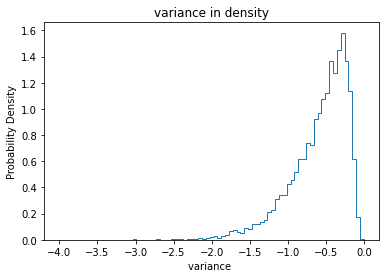

-0.0303745600849567
-2.993166903905524


In [9]:
csv_file = '/home/ajain/cloudphinder/data_all_num_particles>=100'

df = pd.read_csv(csv_file, sep='\t')
data_array = df.to_numpy()

mean= data_array[:, 5].astype(float).reshape(-1)
variance = data_array[:, 6].astype(float).reshape(-1)
density_2d = data_array[:,0].astype(float).reshape(-1)
dispersion_velocity= data_array[: ,2].astype(float).reshape(-1)
galacto_centric_distance=  data_array[:, 3].astype(float).reshape(-1)
projected_distance= data_array[:,4].astype(float).reshape(-1)

new_bins= np.linspace(-4,0,80)
plt.hist(mean,bins=new_bins, density=True, histtype='step')      
plt.title("variance in density")
plt.xlabel("variance ")
plt.ylabel("Probability Density")
#plt.yscale('log')
plt.show()
print(np.max(mean))
print(np.min(mean))

1.9670321826132984
0.2161545050289319


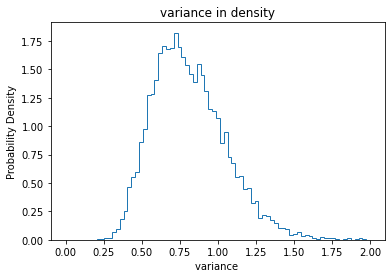

In [7]:
print(np.max(variance))
print(np.min(variance))

new_bins= np.linspace(0,2,80)
plt.hist(variance,bins=new_bins, density=True, histtype='step')      
plt.title("variance in density")
plt.xlabel("variance ")
plt.ylabel("Probability Density")
#plt.yscale('log')
plt.show()

In [10]:
print(np.var(variance))

0.05759906038329529


In [7]:
def cloud_count(dat_file_array, hdf5_file_array):
        count=0
        for dat_file, hdf5_file in zip(dat_file_array, hdf5_file_array):
            file = pd.read_csv(dat_file, sep='\t', header=None, comment='#')
            F = h5py.File(hdf5_file, "r")
            for  cloud in F.keys():
                density_array= np.array(F[cloud + "/PartType0/Masses"][:])*10
                if(len(density_array)>=100):
                    count=count+1
                
        return count

In [9]:
string1= "/home/ajain/cloudphinder/Clouds_312_n1_alpha5.hdf5"
string2= "/home/ajain/cloudphinder/Clouds_356_n1_alpha5.hdf5"
string3= "/home/ajain/cloudphinder/Clouds_382_n1_alpha5.hdf5"
string4= "/home/ajain/cloudphinder/Clouds_412_n1_alpha5.hdf5"
string5= "/home/ajain/cloudphinder/Clouds_534_n1_alpha5.hdf5"
string6= "/home/ajain/cloudphinder/Clouds_591_n1_alpha5.hdf5"
string7= "/home/ajain/cloudphinder/Clouds_600_n1_alpha5.hdf5"
string8= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_312_n1_alpha5.hdf5"
string9= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_356_n1_alpha5.hdf5"
string10= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_382_n1_alpha5.hdf5"
string11= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_412_n1_alpha5.hdf5"
string12= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_534_n1_alpha5.hdf5"
string13= "/home/ajain/cloudphinder/m12f_res7100_output/Clouds_591_n1_alpha5.hdf5"
string14= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_312_n1_alpha5.hdf5"
string15= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_356_n1_alpha5.hdf5"
string16= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_382_n1_alpha5.hdf5"
string17= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_412_n1_alpha5.hdf5"
string18= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_534_n1_alpha5.hdf5"
string19= "/home/ajain/cloudphinder/m12c_res7100_output/Clouds_591_n1_alpha5.hdf5"
string20= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_312_n1_alpha5.hdf5"
string21= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_356_n1_alpha5.hdf5"
string22= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_382_n1_alpha5.hdf5"
string23= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_412_n1_alpha5.hdf5"
string24= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_534_n1_alpha5.hdf5"
string25= "/home/ajain/cloudphinder/m12b_res7100_output/Clouds_591_n1_alpha5.hdf5"


l1= [string1,string2,string3,string4,string5,string6,string7]# string8, string9, string10, string11, string12, string13, string14, string15, string16, string17, string18, string19, string20, string21, string22, string23, string24, string25]
l2= ["/home/ajain/cloudphinder/bound_312_n1_alpha5.dat", 
     "/home/ajain/cloudphinder/bound_356_n1_alpha5.dat",
     "/home/ajain/cloudphinder/bound_382_n1_alpha5.dat",
     "/home/ajain/cloudphinder/bound_412_n1_alpha5.dat",
     "/home/ajain/cloudphinder/bound_534_n1_alpha5.dat" , 
     "/home/ajain/cloudphinder/bound_591_n1_alpha5.dat",
     "/home/ajain/cloudphinder/bound_600_n1_alpha5.dat"]
''' 
     '/home/ajain/cloudphinder/m12f_res7100_output/bound_312_n1_alpha5.dat',
     "/home/ajain/cloudphinder/m12f_res7100_output/bound_356_n1_alpha5.dat", 
     "/home/ajain/cloudphinder/m12f_res7100_output/bound_382_n1_alpha5.dat", 
     '/home/ajain/cloudphinder/m12f_res7100_output/bound_412_n1_alpha5.dat', 
     "/home/ajain/cloudphinder/m12f_res7100_output/bound_534_n1_alpha5.dat", 
     '/home/ajain/cloudphinder/m12f_res7100_output/bound_591_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_312_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_356_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_382_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_412_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_534_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12c_res7100_output/bound_591_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_312_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_356_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_382_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_412_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_534_n1_alpha5.dat',
    '/home/ajain/cloudphinder/m12b_res7100_output/bound_591_n1_alpha5.dat'
    ]'''
c= cloud_count(l2,l1)
print(c)

2132


In [13]:
csv_file = '/home/ajain/cloudphinder/data_all_particles>=100'

df = pd.read_csv(csv_file, sep='\t')
data_array = df.to_numpy()


dispersion_array= data_array[0:2132 ,2].astype(float).reshape(-1)

In [14]:
print(len(dispersion_array))

2132
